Note: Method for Laplacian eigenmaps copies the one detailed in "Laplacian Eigenmaps for Dimensionality Reduction and Data
Representation" (Belkin & Niyogi, 2003).

#### Import Libraries

In [164]:
import pygsp.graphs as graphs
import pygsp
import numpy as np
import scipy
import scipy.sparse as sp
import scipy.spatial.distance as dist
from scipy.linalg import eigh
import sklearn
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as netx

import sparsify

In [165]:
import importlib
importlib.reload(sparsify)

<module 'sparsify' from 'C:\\Users\\cryst\\Desktop\\School\\MATH 322\\sparsify.py'>

In [166]:
def isSymmetric(mat, n):
    for i in range(0, n):
        for j in range(0, n):
            if (mat[i][j] != mat[j][i]):
                return False
    return True

In [167]:
def knn(P, k): # P = a pairwise distance matrix, k = number nearest neighbors
    nonzeroP = P # remove values of 0 when finding nearest neighbors
    nonzeroP[P==0]=['nan']
    nearest_neighbor = np.sort(nonzeroP, axis=0)[k]
    A = np.diag(np.repeat(0, len(P)))
    for i in range(0, len(P)):
        for j in range(0, len(P)):
            # ensure symmetry and a 0-diagonal
            if (P[i,j]!=0 and ((P[i,j] <= nearest_neighbor[i]) \
                            or (P[j,i] <= nearest_neighbor[j]))):
                A[i,j] = 1
    return A

In [168]:
# kth-highest weights
def khw(W, k): # W = weighted affinity matrix, k = number highest weights
    highest_weight = -np.sort(-W, axis=0)[k] # sort descending
    A = np.diag(np.repeat(0.0, len(W))) # cast to float
    for i in range(0, len(W)):
        for j in range(0, len(W)):
            # ensure symmetry and a 0-diagonal
            if ((W[i,j] >= highest_weight[i]) or (W[j,i] >= highest_weight[j])):
                A[i,j] = W[i,j]
    return A

In [169]:
def heat_kernel(x, sig):
    return np.exp(-x**2/(sig))

In [170]:
def apply_heat_kernel(P, A, sig): # P = pairwise distance matrix, A = adjacency matrix, sig = bandwidth
    K = heat_kernel(P, sig)
    W = np.diag(np.repeat(0.0, len(P)))
    for i in range(0, len(P)):
        for j in range(0, len(P)):
            if (A[i,j] == 1 or A[j,i] == 1):
                W[i,j] = K[i,j]
    return W

In [171]:
def compute_laplacian_eigenmap(M, dim): # M = affinity matrix/weighted adjacency matrix, dim = dimensions of embedding
    D = np.diag(list(map(sum, M))) # diagonal degree matrix
    L = D - M # Laplacian
    # compute generalized eigenvector problem
    eigenvalues, eigenvectors = eigh(L, D)
    # get indices of dim smallest nonzero eigenvals
    order = np.argsort(eigenvalues)
    eigenvec = eigenvectors[:, order[1:dim+1]]
    return eigenvec

## Part 1. Constructing Original Laplacian

#### Construct Swiss Roll

In [172]:
# r=radius, h=height, g=noise level
def swiss_roll(npts=1000, r=1, h=20, g=0):
    sr_pts = []
    min_theta = np.pi*1.5
    max_theta = 3*np.pi*1.5
    
    # sample thetas
    thetas = np.random.uniform(np.pi*1.5, 3*np.pi*1.5, npts)
    # sample heights
    heights = np.random.uniform(0, h, npts)
    
    # generate swiss roll points from the parameters
    for i in range(0, npts):
        pt = np.array([r*thetas[i]*np.cos(thetas[i]), r*thetas[i]*np.sin(thetas[i]), heights[i]])
        # normal vector in the 3rd direction
        norm_vec = np.array([pt[0]+pt[1], pt[1]-pt[0], 0])
        normalized_norm_vec = norm_vec/np.linalg.norm(norm_vec)
        # add noise
        new_pt = pt+np.random.randn(1)*g*normalized_norm_vec
        sr_pts.append(new_pt)
    
    return thetas, heights, np.array(sr_pts)

In [182]:
roll = swiss_roll(g=0) # make sample swiss roll with no noise

In [174]:
# set variable for knn
neighbors = 20

#### Construct Adjacency Graph

In [183]:
pairwise_dist = dist.squareform(dist.pdist(roll[2])) 
A = knn(pairwise_dist, neighbors) # use 20th nearest neighbors

#### Add Weights Using Heat Kernel

In [184]:
# use avg dist to 10th nearest neighbor as signal
bandwidth = np.mean(np.sort(pairwise_dist, axis=0)[neighbors])
# pass distances through heat kernel
W = apply_heat_kernel(pairwise_dist, A, bandwidth)

#### Plot

In [185]:
G = graphs.Graph(W)
G.set_coordinates()

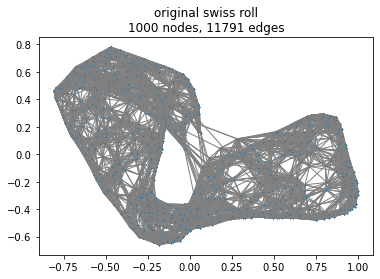

In [186]:
G.plot(vertex_size=2, show_edges = True, plot_name = "original swiss roll\n1000 nodes, " + str(G.Ne) + " edges")

#### Make and Plot Eigenmap

In [187]:
original_lap = compute_laplacian_eigenmap(W, 2)

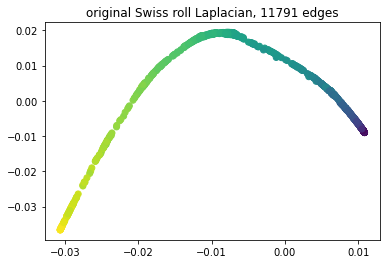

In [188]:
plt.scatter(original_lap[:, 0], original_lap[:, 1], c = roll[0])
plt.title("original Swiss roll Laplacian, " + str(G.Ne) + " edges")
plt.show()

## Part 2. Sparsify

### Naive method: kth highest weights

In [189]:
# narrow down to 10th highest weights
khw_W = khw(W, 10)

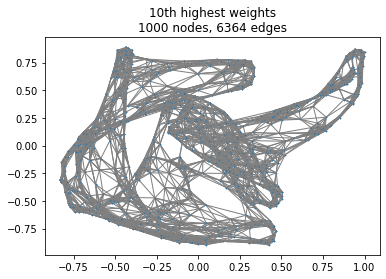

In [190]:
khw_G = graphs.Graph(khw_W)
khw_G.set_coordinates()
khw_G.plot(vertex_size=2, show_edges = True, plot_name = "10th highest weights\n1000 nodes, " + str(khw_G.Ne) + " edges")

### New Method: sparsification algorithm

In [191]:
sparsifier = sparsify.Sparsifier(G, epsilon = 0.2)
sparsifier.sparsify_by_resistances()
G_ = sparsifier.get_sparsifier()

C:\Users\cryst\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\cryst\anaconda3\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
100%|████████████████████████████████████████████████████████████████████████████| 23582/23582 [04:14<00:00, 92.80it/s]


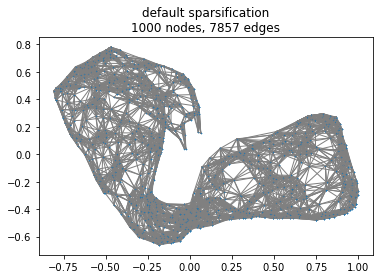

In [192]:
G_.plot(vertex_size=2, show_edges = True, plot_name = "default sparsification\n1000 nodes, " + str(G_.Ne) + " edges")

^ structurally much more similar to the original graph than the khw version

In [193]:
new_W = np.array(G_.W.todense())

#### Limit number of random samples

In [194]:
sparsifier.q = 4000
sparsifier.Sample_Edges()
G__ = sparsifier.get_sparsifier()

  0%|                                                                                         | 0/4000 [00:00<?, ?it/s]C:\Users\cryst\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:53<00:00, 74.70it/s]


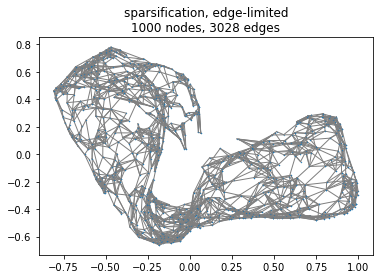

In [195]:
G__.plot(vertex_size=2, show_edges=True, plot_name="sparsification, edge-limited\n1000 nodes, " + str(G__.Ne) + " edges")

In [196]:
new__W = np.array(G__.W.todense())

### Evaluate Laplacian Eigenmap for Sparsified Graphs

##### kth-highest weights

In [197]:
khw_lap = compute_laplacian_eigenmap(khw_W, 2)

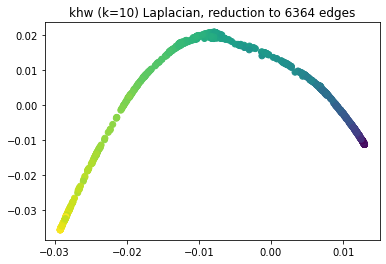

In [198]:
plt.scatter(khw_lap[:, 0], khw_lap[:, 1], c = roll[0])
plt.title("khw (k=10) Laplacian, reduction to " + str(khw_G.Ne) + " edges")
plt.show()

##### default sparsifier

In [199]:
sparse_lap = compute_laplacian_eigenmap(new_W, 2)

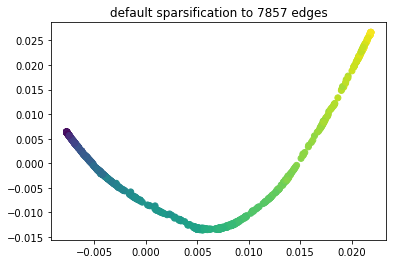

In [200]:
plt.scatter(sparse_lap[:, 0], sparse_lap[:, 1], c = roll[0])
plt.title("default sparsification to " + str(G_.Ne) + " edges")
plt.show()

##### limited sparsifier

In [201]:
sparse__lap = compute_laplacian_eigenmap(new__W, 2)

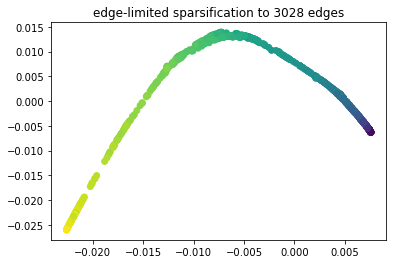

In [202]:
plt.scatter(sparse__lap[:, 0], sparse__lap[:, 1], c = roll[0])
plt.title("edge-limited sparsification to " + str(G__.Ne) + " edges")
plt.show()

### Evaluate Eigenvector Similarity

#### Raw Differences

In [203]:
def print_eigenvector_diff(og, sparse): # og: first 2 Lap eigenvec., sparse: same but with sparsified graph
    dif1 = og[:, 0] - sparse[:, 0]
    dif2 = og[:, 1] - sparse[:, 1]
    
    print("L1 difference between first eigenvectors = " + str(sum(abs(dif1))))
    print("average relative error of " + str(np.mean(abs(dif1)/abs(og[:, 0]))* 100) + "%")

    print("\nL1 difference between second eigenvectors = " + str(sum(abs(dif2))))
    print("average relative error of " + str(np.mean(abs(dif2)/abs(og[:,1]))* 100) + "%")

    print("\nL2 difference between first eigenvectors = " + str(np.linalg.norm(dif1)))
    print("\nL2 difference between second eigenvectors = " + str(np.linalg.norm(dif2)))

##### kth-highest weights

In [204]:
print_eigenvector_diff(original_lap, khw_lap)

L1 difference between first eigenvectors = 1.0385140964044213
average relative error of 12.707177091892206%

L1 difference between second eigenvectors = 1.309947014326881
average relative error of 27.910237999662645%

L2 difference between first eigenvectors = 0.038166608667144664

L2 difference between second eigenvectors = 0.04752440028975339


##### default sparsifier

In [205]:
print_eigenvector_diff(original_lap, sparse_lap)

L1 difference between first eigenvectors = 20.750648562099318
average relative error of 170.50078658414603%

L1 difference between second eigenvectors = 19.43991834099917
average relative error of 171.09705531981464%

L2 difference between first eigenvectors = 0.7775464783978222

L2 difference between second eigenvectors = 0.779292175003078


##### limited sparsifier

In [206]:
print_eigenvector_diff(original_lap, sparse__lap)

L1 difference between first eigenvectors = 3.628820127497794
average relative error of 30.726482429671943%

L1 difference between second eigenvectors = 3.5267773862142344
average relative error of 36.71183619563151%

L2 difference between first eigenvectors = 0.1335507878094783

L2 difference between second eigenvectors = 0.14034003350286087


## Part 3. Variations on Swiss Roll Noise- Optional

khw compared with noisy roll:
L1 difference between first eigenvectors = 0.8898616471016441
average relative error of 15.479538985693534%

L1 difference between second eigenvectors = 1.3904767877774458
average relative error of 59.06392500446904%

L2 difference between first eigenvectors = 0.03497066034028037

L2 difference between second eigenvectors = 0.049045458278705927

khw compared with original roll:
L1 difference between first eigenvectors = 17.36790967313
average relative error of 208.4335909835162%

L1 difference between second eigenvectors = 16.115451185654877
average relative error of 289.52397399120525%

L2 difference between first eigenvectors = 0.6751703243166682

L2 difference between second eigenvectors = 0.6292626668855155


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:54<00:00, 73.08it/s]




SER compared with noisy roll:
L1 difference between first eigenvectors = 3.7061381713189347
average relative error of 38.89207567319099%

L1 difference between second eigenvectors = 4.21653402904422
average relative error of 65.40910999244713%

L2 difference between first eigenvectors = 0.13241101986262302

L2 difference between second eigenvectors = 0.15850391943060224

SER compared with original roll:
L1 difference between first eigenvectors = 14.74098662128828
average relative error of 156.88950656543642%

L1 difference between second eigenvectors = 13.444699534080842
average relative error of 196.36680135367504%

L2 difference between first eigenvectors = 0.5791691243858501

L2 difference between second eigenvectors = 0.5396311876395257
khw compared with noisy roll:
L1 difference between first eigenvectors = 27.64984077302881
average relative error of 237.03393627649012%

L1 difference between second eigenvectors = 27.108527148044658
average relative error of 235.8735181196353%



100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:51<00:00, 77.55it/s]




SER compared with noisy roll:
L1 difference between first eigenvectors = 22.957164078040723
average relative error of 247.48760298908522%

L1 difference between second eigenvectors = 22.211861488593836
average relative error of 197.25799296039693%

L2 difference between first eigenvectors = 0.860002794683747

L2 difference between second eigenvectors = 0.8194385030560128

SER compared with original roll:
L1 difference between first eigenvectors = 15.191756894941676
average relative error of 165.44992211766882%

L1 difference between second eigenvectors = 13.83420757402469
average relative error of 217.66698856840767%

L2 difference between first eigenvectors = 0.5925041579433662

L2 difference between second eigenvectors = 0.5542417227030753
khw compared with noisy roll:
L1 difference between first eigenvectors = 27.28689235472507
average relative error of 231.87494358488738%

L1 difference between second eigenvectors = 30.278235697621458
average relative error of 221.62167151362428%

100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:19<00:00, 202.09it/s]




SER compared with noisy roll:
L1 difference between first eigenvectors = 21.943287785611705
average relative error of 265.88961226642493%

L1 difference between second eigenvectors = 25.059766165339294
average relative error of 193.67852620510973%

L2 difference between first eigenvectors = 0.8230948850873662

L2 difference between second eigenvectors = 0.9074804230893245

SER compared with original roll:
L1 difference between first eigenvectors = 14.691037079845387
average relative error of 165.04016687362395%

L1 difference between second eigenvectors = 14.715762780298506
average relative error of 238.37544888720223%

L2 difference between first eigenvectors = 0.5628849457427398

L2 difference between second eigenvectors = 0.5759402217833748


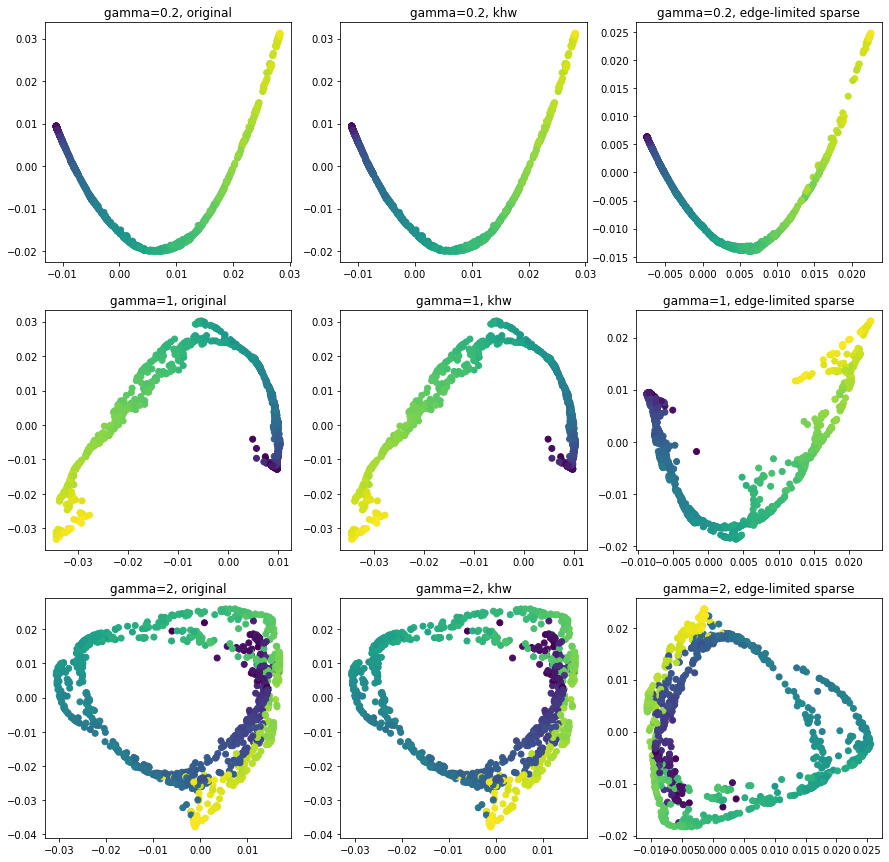

In [212]:
figure, axis = plt.subplots(3,3, figsize=(15,15))

noise_levels = [0.2, 1, 2]
for i in range(0, 3):
    # create noisy swiss roll and corresponding laplacian
    _roll = swiss_roll(g=noise_levels[i])
    _pairwise_dist = dist.squareform(dist.pdist(_roll[2]))
    _A = knn(_pairwise_dist, neighbors)
    _bandwidth = np.mean(np.sort(_pairwise_dist, axis=0)[neighbors])
    _W = apply_heat_kernel(_pairwise_dist, _A, _bandwidth)
    _lap = compute_laplacian_eigenmap(_W, 2)
    
    # graph original eigenmap
    axis[i, 0].scatter(_lap[:, 0], _lap[:, 1], c = _roll[0])
    axis[i, 0].set_title("gamma=" + str(noise_levels[i]) + ", original")
    
    # "sparsify" with khw
    _khw_W = khw(_W, 10)
    _khw_G = graphs.Graph(_khw_W)
    _khw_lap = compute_laplacian_eigenmap(_khw_W, 2)
    
    # get error rate of first eigenvectors
    print("khw compared with noisy roll:")
    print_eigenvector_diff(_lap, _khw_lap)
    print("\nkhw compared with original roll:")
    print_eigenvector_diff(original_lap, _khw_lap)
    
    # graph khw eigenmap
    axis[i, 1].scatter(_lap[:, 0], _lap[:, 1], c = _roll[0])
    axis[i, 1].set_title("gamma=" + str(noise_levels[i]) + ", khw")
    
    # sparsify with algorithm
    _G = graphs.Graph(_W)
    _G.set_coordinates()
    _sparsifier = sparsify.Sparsifier(_G, epsilon = 0.2)
    _sparsifier.sparsify_by_resistances()
    _sparsifier.q = 4000
    _sparsifier.Sample_Edges()
    _new_G = _sparsifier.get_sparsifier()
    _new_W = np.array(_new_G.W.todense()) # sparse weighted affinity matrix
    _new_lap = compute_laplacian_eigenmap(_new_W, 2)
    
    # get diff between first eigenvectors
    print("\n\nSER compared with noisy roll:")
    print_eigenvector_diff(_lap, _new_lap)
    print("\nSER compared with original roll:")
    print_eigenvector_diff(original_lap, _new_lap)
    
    # graph sparsified graph's eigenmap
    axis[i, 2].scatter(_new_lap[:, 0], _new_lap[:, 1], c = _roll[0])
    axis[i, 2].set_title("gamma=" + str(noise_levels[i]) + ", edge-limited sparse")